# code to recreate Figure 3C, 3D, 3E

In [1]:
# Import Libraries
from caveclient import CAVEclient
import pandas as pd
import numpy as np
# import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
# from my_functions import *
# from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
# import matplotlib.patches as mpatches
# import gspread
# from collections import Counter
# import math
# import sys
from functools import reduce

datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

In [2]:
# Specify the root_ids of the sensory neurons that we care about, put them into a list
FeCO_df= client.materialize.query_table('feco_axons_v0')
allFeCO_ids = FeCO_df['pt_root_id'].to_list()
allFeCO_types = FeCO_df['cell_type'].to_list()

ch_df = FeCO_df[FeCO_df['cell_type'].isin(['hook_ext', 'hook_flx', 'claw_ext', 'claw_flx'])]
ch_types = ch_df['cell_type'].to_list()
ch_ids = ch_df['pt_root_id'].to_list()

cl_df = FeCO_df[FeCO_df['cell_type'].isin(['club', 'maybeclub', 'club_asc'])]
cl_types = cl_df['cell_type'].to_list()
cl_ids = cl_df['pt_root_id'].to_list()

FeCO_dict = dict(zip(allFeCO_ids,allFeCO_types))
ch_dict = dict(zip(ch_ids,ch_types))
cl_dict = dict(zip(cl_ids,cl_types))

# Specify the root_ids of the motor neurons that we care about, put them into a list
MN_df = client.materialize.query_table('motor_neuron_table_v7',timestamp='now')
MN_df['pt_position'] = MN_df['pt_position'].apply(lambda x: tuple(x))

ordered_t1_table = client.materialize.live_live_query('left_t1_mn_order_module_table_v1',timestamp='now')
ordered_t1_table['pt_position'] = ordered_t1_table['pt_position'].apply(lambda x: tuple(x))
ordered_t1_table['tag'] = ordered_t1_table['tag'].apply(lambda x: int(x))

MN_df = MN_df.merge(ordered_t1_table,how='right',left_on='pt_position',right_on='pt_position')
MN_df = MN_df[['classification_system','cell_type','pt_position','tag','tag2','pt_root_id_x']]
MN_df = MN_df.rename(columns={'pt_root_id_x':'pt_root_id'})

MN_ids = MN_df.pt_root_id.to_list()
modules = list(set(MN_df['tag2'].to_list()))

syn_threshold = 3; 

In [3]:
#wing MNs (left and right both)
WMN_df = client.materialize.query_table('wing_motor_neuron_table_v0',timestamp='now')
WMN_df['pt_position'] = WMN_df['pt_position'].apply(lambda x: tuple(x))
WMN_df = WMN_df[['classification_system','cell_type','pt_position', 'pt_root_id']]
WMN_ids = WMN_df.pt_root_id.to_list()

# wing motor modules
DLM_clu = ['DLM_1','DLM_2','DLM_3','DLM_4','DLM_5']
DVM_clu = ['DVM_1a','DVM_1b','DVM_1c','DVM_2a','DVM_2b','DVM_3a','DVM_3b']
tension_clu = ['PS1','PS2','dtpmn_u','tp2']
steerA_clu = ['tpn','iii1','iii3']
steerB_clu = ['i2_u','i1','b3_u']
steerC_clu = ['b2','b1']
steerD_clu = ['hg1_u','hg3','hg4','iii4a_u']
hg2_clu = ['hg2']

def fill_wingmm(row):
    if row['cell_type'] in DLM_clu:
        return 'DLM_clu'
    elif row['cell_type'] in DVM_clu:
        return 'DVM_clu'
    elif row['cell_type'] in tension_clu:
        return 'tension_clu'
    elif row['cell_type']  in steerA_clu:
        return 'steerA_clu'
    elif row['cell_type'] in steerB_clu:
        return 'steerB_clu'
    elif row['cell_type'] in steerC_clu:
        return 'steerC_clu'
    elif row['cell_type'] in steerD_clu:
        return 'steerD_clu'
    elif row['cell_type'] in hg2_clu:
        return 'hg2_clu'
    else:
        return row['cell_type']



WMN_df['modules'] = WMN_df.apply(lambda row : fill_wingmm(row), axis=1) 
# WMN_df = WMN_df[['classification_system','modules','pt_position', 'pt_root_id']]

Wmodules = list(set(WMN_df['modules'].to_list()))


In [4]:
synapse_in_counts = client.materialize.query_view('synapse_in_counts', filter_in_dict={'root_id': MN_ids})
MN_df = (MN_df.merge(synapse_in_counts, left_on='pt_root_id', right_on='root_id').reindex(columns=['classification_system', 'cell_type', 'pt_root_id', 'tag1', 'tag2', 'n_input']))    

synapse_in_counts = client.materialize.query_view('synapse_in_counts', filter_in_dict={'root_id': WMN_ids})
WMN_df = (WMN_df.merge(synapse_in_counts, left_on='pt_root_id', right_on='root_id').reindex(columns=['classification_system','cell_type','pt_position', 'pt_root_id', 'modules', 'n_input']))    


### FeCO to leg MN impact score

In [5]:
# find all monosynaptic connections between FeCO SNs and leg MNs
syn_per_DS1 = pd.DataFrame()

#first term
DS1 = client.materialize.synapse_query(pre_ids = allFeCO_ids, post_ids = MN_ids)
syn_per_DS1 = DS1.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_DS1 = syn_per_DS1[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_DS1['number_of_synapses'] > syn_threshold]

syn_per_DS1 = pd.merge(syn_per_DS1,MN_df, how='left', left_on='post_pt_root_id', right_on='pt_root_id')[['pre_pt_root_id', 'post_pt_root_id', 'number_of_synapses', 'n_input']]

syn_per_DS1['impact'] = syn_per_DS1['number_of_synapses']/syn_per_DS1['n_input']
syn_per_DS1 = syn_per_DS1.rename(columns={"pre_pt_root_id": "SN", "post_pt_root_id": "MN"}, errors="raise")
syn_per_DS1['SN_type'] = syn_per_DS1['SN'].map(FeCO_dict)

In [6]:
#all disynaptic connections between FeCO SNs and MNs
syn_per_DS2 = pd.DataFrame()

all_firstouts = client.materialize.synapse_query(pre_ids = allFeCO_ids)
syn_per_firstouts = all_firstouts.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_firstouts = syn_per_firstouts[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_firstouts['number_of_synapses'] > syn_threshold]
firstouts_ids = syn_per_firstouts.drop_duplicates(subset = "post_pt_root_id")['post_pt_root_id'].to_list()   
        
synapse_in_counts = client.materialize.query_view('synapse_in_counts', filter_in_dict={'root_id': firstouts_ids})      
inputs_per_id = dict(zip(synapse_in_counts.root_id.tolist(), synapse_in_counts.n_input.tolist())) #create dictionary with the seg_id and the number of input synapses

syn_per_firstouts['num_inputs'] = syn_per_firstouts['post_pt_root_id'].map(inputs_per_id)
syn_per_firstouts['SN_to_IN1'] = syn_per_firstouts['number_of_synapses']/syn_per_firstouts['num_inputs']

#now find out which of those outputs is presynaptic to MNs
DS2 = client.materialize.synapse_query(pre_ids = firstouts_ids, post_ids = MN_ids)
syn_per_DS2 = DS2.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_DS2 = syn_per_DS2[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_DS2['number_of_synapses'] > syn_threshold]

syn_per_DS2 = pd.merge(syn_per_DS2,MN_df, how='left', left_on='post_pt_root_id', right_on='pt_root_id')[['pre_pt_root_id', 'post_pt_root_id', 'number_of_synapses', 'n_input']]
syn_per_DS2['IN1_to_MN'] = syn_per_DS2['number_of_synapses']/syn_per_DS2['n_input']

#lets rename stuff to make our lives easier
syn_per_DS2 = syn_per_DS2.rename(columns={"pre_pt_root_id": "IN1", "post_pt_root_id": "MN"}, errors="raise")
syn_per_firstouts = syn_per_firstouts.rename(columns={"pre_pt_root_id": "SN", "post_pt_root_id": "IN1"}, errors="raise")

#merge the SN>IN to syn_per_DS2
syn_per_DS2 = pd.merge(syn_per_DS2,syn_per_firstouts, how='left', left_on='IN1', right_on='IN1')[['SN', 'IN1', 'MN', 'SN_to_IN1', 'IN1_to_MN']]
syn_per_DS2['impact'] = syn_per_DS2['SN_to_IN1']*syn_per_DS2['IN1_to_MN']
syn_per_DS2['SN_type'] = syn_per_DS2['SN'].map(FeCO_dict)

In [7]:
#all trisynaptic connections between FeCO SNs and MNs
syn_per_DS3 = pd.DataFrame()


#lets find all the second order INs. We need to batch this up because there are so many IN1, facing the query limit.
#batch up firstouts_ids:
switch = 0
for i in range(0, len(firstouts_ids), 30):
    chunk = firstouts_ids[i:(i + 30)]
    if switch == 0:
        all_secondouts = client.materialize.synapse_query(pre_ids = chunk)
        switch = 1
    else:
        all_secondouts.attrs = {}
        theseoutputs = client.materialize.synapse_query(pre_ids = chunk)
        theseoutputs.attrs = {}
        
        all_secondouts = pd.concat([all_secondouts, theseoutputs], ignore_index=True)

syn_per_secondouts = all_secondouts.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_secondouts = syn_per_secondouts[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_secondouts['number_of_synapses'] > syn_threshold]
secondouts_ids = syn_per_secondouts.drop_duplicates(subset = "post_pt_root_id")['post_pt_root_id'].to_list()

#now need to find all the connections between secondouts and MNs, also batched
switch = 0
for i in range(0, len(secondouts_ids), 50):
    chunk = secondouts_ids[i:(i + 50)]
    if switch == 0:
        DS3 = client.materialize.synapse_query(pre_ids = chunk, post_ids = MN_ids)
        switch = 1
    else:
        DS3.attrs = {}
        thesesyns = client.materialize.synapse_query(pre_ids = chunk, post_ids = MN_ids)
        thesesyns.attrs = {}
        DS3 = pd.concat([DS3, thesesyns], ignore_index=True)

# # DS3 = client.materialize.synapse_query(pre_ids = secondouts_ids, post_ids = MN_ids)
syn_per_DS3 = DS3.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_DS3 = syn_per_DS3[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_DS3['number_of_synapses'] > syn_threshold]
syn_per_DS3 = syn_per_DS3.rename(columns={"pre_pt_root_id": "IN2", "post_pt_root_id": "MN"}, errors="raise")

#merge in # of MN inputs, so that we can easily calculate IN2>MN impact
syn_per_DS3 = pd.merge(syn_per_DS3,MN_df, how='left', left_on='MN', right_on='pt_root_id')[['IN2', 'MN', 'number_of_synapses', 'n_input']]
syn_per_DS3['IN2_to_MN'] = syn_per_DS3['number_of_synapses']/syn_per_DS3['n_input']

#now lets figure out the IN1>IN2 impact. We'll only do this for the IN2 that output to MNs since we are not planning to calculate the 4th term for now
MNfiltered_secondouts_ids = syn_per_DS3.drop_duplicates(subset = "IN2")['IN2'].to_list()
        
synapse_in_counts = client.materialize.query_view('synapse_in_counts', filter_in_dict={'root_id': MNfiltered_secondouts_ids})      
inputs_per_id = dict(zip(synapse_in_counts.root_id.tolist(), synapse_in_counts.n_input.tolist())) #create dictionary with the seg_id and the number of input synapses
        

syn_per_secondouts['num_inputs'] = syn_per_secondouts['post_pt_root_id'].map(inputs_per_id)
syn_per_secondouts['IN1_to_IN2'] = syn_per_secondouts['number_of_synapses']/syn_per_secondouts['num_inputs']
syn_per_secondouts = syn_per_secondouts.rename(columns={"pre_pt_root_id": "IN1", "post_pt_root_id": "IN2"}, errors="raise")
syn_per_DS3 = pd.merge(syn_per_DS3,syn_per_secondouts, how='left', left_on='IN2', right_on='IN2')[['IN1', 'IN2', 'MN', 'IN1_to_IN2', 'IN2_to_MN']]

#merge in SN>IN1 information
syn_per_DS3 = pd.merge(syn_per_DS3,syn_per_firstouts, how='left', left_on='IN1', right_on='IN1')[['SN', 'IN1', 'IN2', 'MN', 'SN_to_IN1', 'IN1_to_IN2', 'IN2_to_MN']]

#calculate impact
syn_per_DS3['impact'] = syn_per_DS3['SN_to_IN1']*syn_per_DS3['IN1_to_IN2']*syn_per_DS3['IN2_to_MN']
syn_per_DS3['SN_type'] = syn_per_DS3['SN'].map(FeCO_dict)

In [8]:
# load in the downstream neuron table, and then separate it into the various subtypes that we care about
# each hemilineage, excitatory, inhibitory, premotor, ascending, intersegmental, local

DS_df= pd.concat([client.materialize.query_table('left_t1_local_premotor_table_v6'),
                  client.materialize.query_table('downstream_feco_axons_v1'), 
                  client.materialize.query_table('wing_premotor_v4')],
                  axis=0)

# DS_df=client.materialize.query_table('downstream_feco_axons_v1')

Ach_HL = ['1A', '3A', '4B', '7B', '8B', '01A', '03A', '04B', '07B', '08B', '10B', '11A', '12A', '17A', '18B', '19B', 
          '20A', '22A', '23B', 'MN', 'sensory', 'hook', 'hair_plate', 'claw', 'club']

Glu_HL = ['2A', '8A', '9B', '02A', '08A', '09B', '14A', '15B', '16B', '21A', '24B']

GABA_HL = ['0A/0B', '1B', '3B', '5B', '9A','01B', '03B', '05B', '09A', '12B/6A', '6B', '11B', '13A', 
           '13B', '19A']

U_HL = ['10B-like', '16A', 'unknown']

def fill_NT(row):
    if row['cell_type'] in Glu_HL:
        return 'Glu'
    elif row['cell_type'] in Ach_HL:
        return 'Ach'
    elif row['cell_type'] in GABA_HL:
        return 'GABA'
    elif row['cell_type'] == 'fragment':
        return 'fragment'
    else:
        return 'U'
    
def fill_sign(row):
    if row['cell_type'] in Glu_HL:
        return 'I'
    elif row['cell_type'] in Ach_HL:
        return 'E'
    elif row['cell_type'] in GABA_HL:
        return 'I'
    elif row['cell_type'] == 'fragment':
        return 'fragment'
    else:
        return 'U'
    
    
DS_df['NT'] = DS_df.apply(lambda row : fill_NT(row), axis=1) 
DS_df['sign'] = DS_df.apply(lambda row : fill_sign(row), axis=1) 

excitatory_df = DS_df[DS_df['sign'] == 'E']
inhibitory_df = DS_df[DS_df['sign'] == 'I']

glu_df = DS_df[DS_df['NT'] == 'Glu']
gaba_df = DS_df[DS_df['NT'] == 'GABA']
ach_df = DS_df[DS_df['NT'] == 'Ach']

U_df = DS_df[DS_df['NT'] == 'U']

In [9]:
#calculate DS2 for only the ibhibitory or excitatory terms

#pull out a list of the inhibitory/excitatory ids that we care about

e_ids = excitatory_df['pt_root_id'].to_list()
i_ids = inhibitory_df['pt_root_id'].to_list()
ei_ids = e_ids+i_ids

#subset DS2 accordingly
syn_per_eDS2 = syn_per_DS2.query('IN1 in @e_ids')
syn_per_iDS2 = syn_per_DS2.query('IN1 in @i_ids')


#subset DS3 accordingly
syn_per_eDS3 = pd.concat([syn_per_DS3[syn_per_DS3['IN1'].isin(e_ids) & syn_per_DS3['IN2'].isin(e_ids)],
                          syn_per_DS3[syn_per_DS3['IN1'].isin(i_ids) & syn_per_DS3['IN2'].isin(i_ids)]],
                         axis=0)
                          

syn_per_iDS3 = pd.concat([syn_per_DS3[syn_per_DS3['IN1'].isin(e_ids) & syn_per_DS3['IN2'].isin(i_ids)],
                          syn_per_DS3[syn_per_DS3['IN1'].isin(i_ids) & syn_per_DS3['IN2'].isin(e_ids)]],
                         axis=0)

In [10]:
# so now all impact data stored in syn_per_DS1 (first term), syn_per_DS2 (second term), syn_per_DS3 (third term)
# we can now slice it as needed for whatever impact values we want to calculate

impact_df = pd.DataFrame()

#impact from each FeCO onto the different motor modules
switch = 0
for module in modules:
    thismodule_ids = MN_df.query("tag2 in [@module]")['pt_root_id'].to_list()
    term_dfs = [syn_per_DS1[syn_per_DS1['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "firstterm"}), 
                syn_per_DS2[syn_per_DS2['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "secondterm"}),
                syn_per_DS3[syn_per_DS3['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "thirdterm"})]

    #merge into one giant DF, then sum across the sensory neurons
    if switch == 0:
        impact_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), term_dfs).fillna(0)
        if pd.isna(module):
            print("module is nan!")
        else:
            pp_column = [module]*len(impact_df)
            switch = 1
    else:
        if pd.isna(module):
            print("module is nan!")
        else:
            merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), term_dfs).fillna(0)
            impact_df = pd.concat([impact_df, merged_df])
            pp_column.append([module]*len(merged_df))

def flatten_to_strings(listOfLists):
    """Flatten a list of (lists of (lists of strings)) for any level 
    of nesting"""
    result = []

    for i in listOfLists:
        # Only append if i is a basestring (superclass of string)
        if isinstance(i, str):
            result.append(i)
        # Otherwise call this function recursively
        else:
            result.extend(flatten_to_strings(i))
    return result


impact_df['module'] = flatten_to_strings(pp_column)
impact_df['SN_type'] = impact_df['SN'].map(FeCO_dict)
impact_df['total_impact']=impact_df[['firstterm', 'secondterm', 'thirdterm']].sum(axis=1)
impact_df = impact_df[['SN', 'SN_type', 'firstterm', 'secondterm', 'thirdterm', 'total_impact', 'module']]

In [11]:
#calculate impact taking into account the sign info from above
# so now all impact data stored in syn_per_DS1 (first term), syn_per_eDS2 and syn_per_iDS2 (second term), 
# syn_per_eDS3 and syn_per_iDS3 (third term)

#impact from each FeCO onto the different motor modules
switch = 0
for module in modules:
    thismodule_ids = MN_df.query("tag2 in [@module]")['pt_root_id'].to_list()
    i_term_dfs = [syn_per_iDS2[syn_per_iDS2['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "secondterm"}),
                  syn_per_iDS3[syn_per_iDS3['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "thirdterm"})]

    
    e_term_dfs = [syn_per_DS1[syn_per_DS1['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "firstterm"}), 
                syn_per_eDS2[syn_per_eDS2['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "secondterm"}),
                syn_per_eDS3[syn_per_eDS3['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "thirdterm"})]

    #merge into one giant DF, then sum across the sensory neurons
    if switch == 0:
        i_impact_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), i_term_dfs).fillna(0)
        e_impact_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), e_term_dfs).fillna(0)
        if pd.isna(module):
            print("module is nan!")
        else:
            i_pp_column = [module]*len(i_impact_df)
            e_pp_column = [module]*len(e_impact_df)
            switch = 1
        
    else:
        if pd.isna(module):
            print("module is nan!")
        else:
            i_merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), i_term_dfs).fillna(0)
            i_impact_df = pd.concat([i_impact_df, i_merged_df])
            i_pp_column.append([module]*len(i_merged_df))
        
            e_merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), e_term_dfs).fillna(0)
            e_impact_df = pd.concat([e_impact_df, e_merged_df])
            e_pp_column.append([module]*len(e_merged_df))
            

            
i_impact_df['module'] = flatten_to_strings(i_pp_column)
i_impact_df['SN_type'] = i_impact_df['SN'].map(FeCO_dict)
i_impact_df['i_total_impact']=i_impact_df[['secondterm']].sum(axis=1)
i_impact_df = i_impact_df[['SN', 'i_total_impact', 'module']]

e_impact_df['module'] = flatten_to_strings(e_pp_column)
e_impact_df['SN_type'] = e_impact_df['SN'].map(FeCO_dict)
e_impact_df['e_total_impact']=e_impact_df[['firstterm', 'secondterm']].sum(axis=1)
e_impact_df = e_impact_df[['SN', 'e_total_impact', 'module']]

In [12]:
# merge into impact_df the inhibitory/excitatory imapct scores and a total signed impact score

impact_df = pd.merge(impact_df, e_impact_df,  how='left', left_on=['SN','module'], right_on = ['SN','module']).fillna(0)
impact_df = pd.merge(impact_df, i_impact_df,  how='left', left_on=['SN','module'], right_on = ['SN','module']).fillna(0)

impact_df['signed_impact'] = impact_df['e_total_impact']-impact_df['i_total_impact']

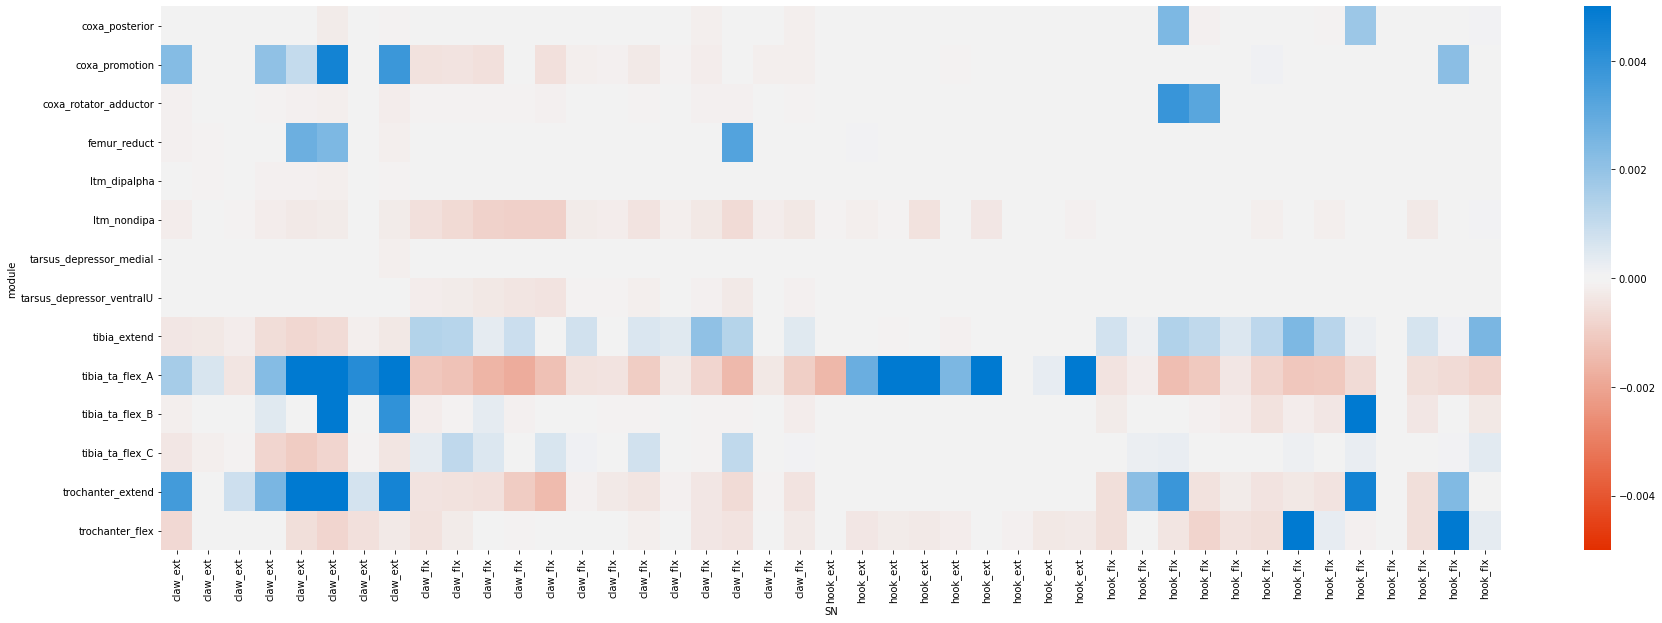

In [13]:
#plot heat map for summed excitatory and inhibitory information
summed_cmap = sns.diverging_palette(15, 250, l=50, s=100, as_cmap=True, sep=5)#sns.color_palette("icefire_r", as_cmap=True)
figure_size = [30,10]


fig = plt.figure(1, figsize = figure_size)
thisdata = impact_df[impact_df['SN_type'].isin(['hook_ext', 'hook_flx', 'claw_ext', 'claw_flx'])].pivot(index = 'module', columns = 'SN', values = 'signed_impact').fillna(0)

ch_dict = dict(sorted(ch_dict.items(), key=lambda item: item[1])) #sorting this dictionary to get columns into a general order
thisdata = thisdata[list(ch_dict.keys())]
thisdata = thisdata.rename(columns=ch_dict)


ax = sns.heatmap(data = thisdata, cmap=summed_cmap, vmin=-0.005, vmax=0.005)#, norm=LogNorm())

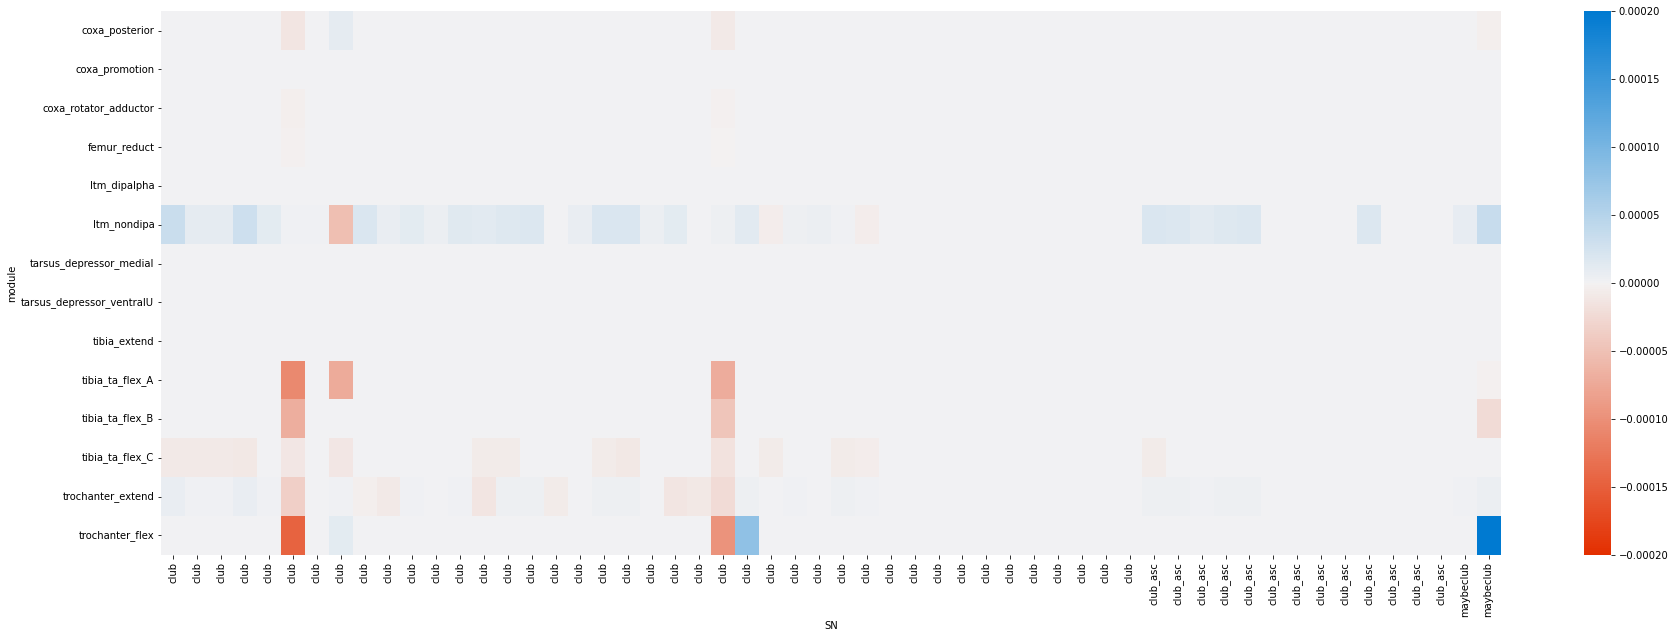

In [14]:
#plot heat map for summed excitatory and inhibitory information
summed_cmap = sns.diverging_palette(15, 250, l=50, s=100, as_cmap=True, sep=1)#sns.color_palette("icefire_r", as_cmap=True)
figure_size = [30,10]


fig = plt.figure(1, figsize = figure_size)
thisdata = impact_df[impact_df['SN_type'].isin(['club', 'maybeclub', 'club_asc'])].pivot(index = 'module', columns = 'SN', values = 'signed_impact').fillna(0)


cl_dict = dict(sorted(cl_dict.items(), key=lambda item: item[1])) #sorting this dictionary to get columns into a general order
thisdata = thisdata[list(cl_dict.keys())]
thisdata = thisdata.rename(columns=cl_dict)

ax = sns.heatmap(data = thisdata, cmap=summed_cmap, vmin=-0.0002, vmax=0.0002)

### FeCO to wing MN impact

In [15]:
# find all monosynaptic connections between FeCO SNs and leg MNs
w_syn_per_DS1 = pd.DataFrame()

#first term
w_DS1 = client.materialize.synapse_query(pre_ids = allFeCO_ids, post_ids = WMN_ids)
w_syn_per_DS1 = w_DS1.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
w_syn_per_DS1 = w_syn_per_DS1[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][w_syn_per_DS1['number_of_synapses'] > syn_threshold]

w_syn_per_DS1 = pd.merge(w_syn_per_DS1,WMN_df, how='left', left_on='post_pt_root_id', right_on='pt_root_id')[['pre_pt_root_id', 'post_pt_root_id', 'number_of_synapses', 'n_input']]

w_syn_per_DS1['impact'] = w_syn_per_DS1['number_of_synapses']/w_syn_per_DS1['n_input']
w_syn_per_DS1 = w_syn_per_DS1.rename(columns={"pre_pt_root_id": "SN", "post_pt_root_id": "MN"}, errors="raise")
w_syn_per_DS1['SN_type'] = w_syn_per_DS1['SN'].map(FeCO_dict)

In [16]:
#all disynaptic connections between FeCO SNs and MNs
w_syn_per_DS2 = pd.DataFrame()

all_firstouts = client.materialize.synapse_query(pre_ids = allFeCO_ids)
syn_per_firstouts = all_firstouts.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_firstouts = syn_per_firstouts[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_firstouts['number_of_synapses'] > syn_threshold]
firstouts_ids = syn_per_firstouts.drop_duplicates(subset = "post_pt_root_id")['post_pt_root_id'].to_list()   
        
synapse_in_counts = client.materialize.query_view('synapse_in_counts', filter_in_dict={'root_id': firstouts_ids})      
inputs_per_id = dict(zip(synapse_in_counts.root_id.tolist(), synapse_in_counts.n_input.tolist())) #create dictionary with the seg_id and the number of input synapses

syn_per_firstouts['num_inputs'] = syn_per_firstouts['post_pt_root_id'].map(inputs_per_id)
syn_per_firstouts['SN_to_IN1'] = syn_per_firstouts['number_of_synapses']/syn_per_firstouts['num_inputs']

#now find out which of those outputs is presynaptic to MNs
w_DS2 = client.materialize.synapse_query(pre_ids = firstouts_ids, post_ids = WMN_ids)
w_syn_per_DS2 = w_DS2.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
w_syn_per_DS2 = w_syn_per_DS2[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][w_syn_per_DS2['number_of_synapses'] > syn_threshold]

w_syn_per_DS2 = pd.merge(w_syn_per_DS2,WMN_df, how='left', left_on='post_pt_root_id', right_on='pt_root_id')[['pre_pt_root_id', 'post_pt_root_id', 'number_of_synapses', 'n_input']]
w_syn_per_DS2['IN1_to_MN'] = w_syn_per_DS2['number_of_synapses']/w_syn_per_DS2['n_input']

#lets rename stuff to make our lives easier
w_syn_per_DS2 = w_syn_per_DS2.rename(columns={"pre_pt_root_id": "IN1", "post_pt_root_id": "MN"}, errors="raise")
syn_per_firstouts = syn_per_firstouts.rename(columns={"pre_pt_root_id": "SN", "post_pt_root_id": "IN1"}, errors="raise")

#merge the SN>IN to w_syn_per_DS2
w_syn_per_DS2 = pd.merge(w_syn_per_DS2,syn_per_firstouts, how='left', left_on='IN1', right_on='IN1')[['SN', 'IN1', 'MN', 'SN_to_IN1', 'IN1_to_MN']]
w_syn_per_DS2['impact'] = w_syn_per_DS2['SN_to_IN1']*w_syn_per_DS2['IN1_to_MN']
w_syn_per_DS2['SN_type'] = w_syn_per_DS2['SN'].map(FeCO_dict)

In [17]:
#all trisynaptic connections between FeCO SNs and MNs
w_syn_per_DS3 = pd.DataFrame()


#lets find all the second order INs. We need to batch this up because there are so many IN1, facing the query limit.
#batch up firstouts_ids:
switch = 0
for i in range(0, len(firstouts_ids), 30):
    chunk = firstouts_ids[i:(i + 30)]
    if switch == 0:
        all_secondouts = client.materialize.synapse_query(pre_ids = chunk)
        switch = 1
    else:
        all_secondouts.attrs = {}
        theseoutputs = client.materialize.synapse_query(pre_ids = chunk)
        theseoutputs.attrs = {}
        
        all_secondouts = pd.concat([all_secondouts, theseoutputs], ignore_index=True)

syn_per_secondouts = all_secondouts.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_secondouts = syn_per_secondouts[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_secondouts['number_of_synapses'] > syn_threshold]
secondouts_ids = syn_per_secondouts.drop_duplicates(subset = "post_pt_root_id")['post_pt_root_id'].to_list()

#now need to find all the connections between secondouts and MNs, also batched
switch = 0
for i in range(0, len(secondouts_ids), 50):
    chunk = secondouts_ids[i:(i + 50)]
    if switch == 0:
        w_DS3 = client.materialize.synapse_query(pre_ids = chunk, post_ids = WMN_ids)
        switch = 1
    else:
        w_DS3.attrs = {}
        thesesyns = client.materialize.synapse_query(pre_ids = chunk, post_ids = WMN_ids)
        thesesyns.attrs = {}
        w_DS3 = pd.concat([w_DS3, thesesyns], ignore_index=True)

# # DS3 = client.materialize.synapse_query(pre_ids = secondouts_ids, post_ids = MN_ids)
w_syn_per_DS3 = w_DS3.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
w_syn_per_DS3 = w_syn_per_DS3[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][w_syn_per_DS3['number_of_synapses'] > syn_threshold]
w_syn_per_DS3 = w_syn_per_DS3.rename(columns={"pre_pt_root_id": "IN2", "post_pt_root_id": "MN"}, errors="raise")

#merge in # of MN inputs, so that we can easily calculate IN2>MN impact
w_syn_per_DS3 = pd.merge(w_syn_per_DS3,WMN_df, how='left', left_on='MN', right_on='pt_root_id')[['IN2', 'MN', 'number_of_synapses', 'n_input']]
w_syn_per_DS3['IN2_to_MN'] = w_syn_per_DS3['number_of_synapses']/w_syn_per_DS3['n_input']

#now lets figure out the IN1>IN2 impact. We'll only do this for the IN2 that output to MNs since we are not planning to calculate the 4th term for now
WMNfiltered_secondouts_ids = w_syn_per_DS3.drop_duplicates(subset = "IN2")['IN2'].to_list()
        
synapse_in_counts = client.materialize.query_view('synapse_in_counts', filter_in_dict={'root_id': WMNfiltered_secondouts_ids})      
inputs_per_id = dict(zip(synapse_in_counts.root_id.tolist(), synapse_in_counts.n_input.tolist())) #create dictionary with the seg_id and the number of input synapses
        

syn_per_secondouts['num_inputs'] = syn_per_secondouts['post_pt_root_id'].map(inputs_per_id)
syn_per_secondouts['IN1_to_IN2'] = syn_per_secondouts['number_of_synapses']/syn_per_secondouts['num_inputs']
syn_per_secondouts = syn_per_secondouts.rename(columns={"pre_pt_root_id": "IN1", "post_pt_root_id": "IN2"}, errors="raise")
w_syn_per_DS3 = pd.merge(w_syn_per_DS3,syn_per_secondouts, how='left', left_on='IN2', right_on='IN2')[['IN1', 'IN2', 'MN', 'IN1_to_IN2', 'IN2_to_MN']]

#merge in SN>IN1 information
w_syn_per_DS3 = pd.merge(w_syn_per_DS3,syn_per_firstouts, how='left', left_on='IN1', right_on='IN1')[['SN', 'IN1', 'IN2', 'MN', 'SN_to_IN1', 'IN1_to_IN2', 'IN2_to_MN']]

#calculate impact
w_syn_per_DS3['impact'] = w_syn_per_DS3['SN_to_IN1']*w_syn_per_DS3['IN1_to_IN2']*w_syn_per_DS3['IN2_to_MN']
w_syn_per_DS3['SN_type'] = w_syn_per_DS3['SN'].map(FeCO_dict)

In [18]:
#subset DS2 accordingly
w_syn_per_eDS2 = w_syn_per_DS2.query('IN1 in @e_ids')
w_syn_per_iDS2 = w_syn_per_DS2.query('IN1 in @i_ids')


#subset DS3 accordingly
w_syn_per_eDS3 = pd.concat([w_syn_per_DS3[syn_per_DS3['IN1'].isin(e_ids) & w_syn_per_DS3['IN2'].isin(e_ids)],
                          w_syn_per_DS3[w_syn_per_DS3['IN1'].isin(i_ids) & w_syn_per_DS3['IN2'].isin(i_ids)]],
                         axis=0)
                          

w_syn_per_iDS3 = pd.concat([w_syn_per_DS3[w_syn_per_DS3['IN1'].isin(e_ids) & w_syn_per_DS3['IN2'].isin(i_ids)],
                          w_syn_per_DS3[w_syn_per_DS3['IN1'].isin(i_ids) & w_syn_per_DS3['IN2'].isin(e_ids)]],
                         axis=0)

C:\Users\swetarr\AppData\Local\Temp\ipykernel_22452\3231922678.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  w_syn_per_eDS3 = pd.concat([w_syn_per_DS3[syn_per_DS3['IN1'].isin(e_ids) & w_syn_per_DS3['IN2'].isin(e_ids)],


In [19]:
# so now all impact data stored in syn_per_DS1 (first term), syn_per_DS2 (second term), syn_per_DS3 (third term)
# we can now slice it as needed for whatever impact values we want to calculate

w_impact_df = pd.DataFrame()

#impact from each FeCO onto the different motor modules
switch = 0
for module in Wmodules:
    thismodule_ids = WMN_df.query("modules in [@module]")['pt_root_id'].to_list()
    term_dfs = [w_syn_per_DS1[w_syn_per_DS1['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "firstterm"}), 
                w_syn_per_DS2[w_syn_per_DS2['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "secondterm"}),
                w_syn_per_DS3[w_syn_per_DS3['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "thirdterm"})]

    #merge into one giant DF, then sum across the sensory neurons
    if switch == 0:
        w_impact_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), term_dfs).fillna(0)
        if pd.isna(module):
            print("module is nan!")
        else:
            pp_column = [module]*len(w_impact_df)
            switch = 1
    else:
        if pd.isna(module):
            print("module is nan!")
        else:
            merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), term_dfs).fillna(0)
            w_impact_df = pd.concat([w_impact_df, merged_df])
            pp_column.append([module]*len(merged_df))

def flatten_to_strings(listOfLists):
    """Flatten a list of (lists of (lists of strings)) for any level 
    of nesting"""
    result = []

    for i in listOfLists:
        # Only append if i is a basestring (superclass of string)
        if isinstance(i, str):
            result.append(i)
        # Otherwise call this function recursively
        else:
            result.extend(flatten_to_strings(i))
    return result


w_impact_df['module'] = flatten_to_strings(pp_column)
w_impact_df['SN_type'] = w_impact_df['SN'].map(FeCO_dict)
w_impact_df['total_impact']=w_impact_df[['firstterm', 'secondterm', 'thirdterm']].sum(axis=1)
w_impact_df = w_impact_df[['SN', 'SN_type', 'firstterm', 'secondterm', 'thirdterm', 'total_impact', 'module']]

In [20]:
#calculate impact taking into account the sign info from above
# so now all impact data stored in syn_per_DS1 (first term), syn_per_eDS2 and syn_per_iDS2 (second term), 
# syn_per_eDS3 and syn_per_iDS3 (third term)

#impact from each FeCO onto the different motor modules
switch = 0
for module in Wmodules:
    thismodule_ids = WMN_df.query("modules in [@module]")['pt_root_id'].to_list()
    i_term_dfs = [w_syn_per_iDS2[w_syn_per_iDS2['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "secondterm"}),
                  w_syn_per_iDS3[w_syn_per_iDS3['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "thirdterm"})]

    
    e_term_dfs = [w_syn_per_DS1[w_syn_per_DS1['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "firstterm"}), 
                w_syn_per_eDS2[w_syn_per_eDS2['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "secondterm"}),
                w_syn_per_eDS3[w_syn_per_eDS3['MN'].isin(thismodule_ids)].groupby(["SN"]).impact.sum().reset_index().rename(columns={"impact": "thirdterm"})]

    #merge into one giant DF, then sum across the sensory neurons
    if switch == 0:
        w_i_impact_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), i_term_dfs).fillna(0)
        w_e_impact_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), e_term_dfs).fillna(0)
        if pd.isna(module):
            print("module is nan!")
        else:
            i_pp_column = [module]*len(w_i_impact_df)
            e_pp_column = [module]*len(w_e_impact_df)
            switch = 1
        
    else:
        if pd.isna(module):
            print("module is nan!")
        else:
            i_merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), i_term_dfs).fillna(0)
            w_i_impact_df = pd.concat([w_i_impact_df, i_merged_df])
            i_pp_column.append([module]*len(i_merged_df))
        
            e_merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['SN'], how='outer'), e_term_dfs).fillna(0)
            w_e_impact_df = pd.concat([w_e_impact_df, e_merged_df])
            e_pp_column.append([module]*len(e_merged_df))
            

            
w_i_impact_df['module'] = flatten_to_strings(i_pp_column)
w_i_impact_df['SN_type'] = w_i_impact_df['SN'].map(FeCO_dict)
w_i_impact_df['i_total_impact']=w_i_impact_df[['secondterm']].sum(axis=1)
w_i_impact_df = w_i_impact_df[['SN', 'i_total_impact', 'module']]

w_e_impact_df['module'] = flatten_to_strings(e_pp_column)
w_e_impact_df['SN_type'] = w_e_impact_df['SN'].map(FeCO_dict)
w_e_impact_df['e_total_impact']=w_e_impact_df[['firstterm', 'secondterm']].sum(axis=1)
w_e_impact_df = w_e_impact_df[['SN', 'e_total_impact', 'module']]

In [21]:
# merge into impact_df the inhibitory/excitatory imapct scores and a total signed impact score

w_impact_df = pd.merge(w_impact_df, w_e_impact_df,  how='left', left_on=['SN','module'], right_on = ['SN','module']).fillna(0)
w_impact_df = pd.merge(w_impact_df, w_i_impact_df,  how='left', left_on=['SN','module'], right_on = ['SN','module']).fillna(0)

w_impact_df['signed_impact'] = w_impact_df['e_total_impact']-w_impact_df['i_total_impact']

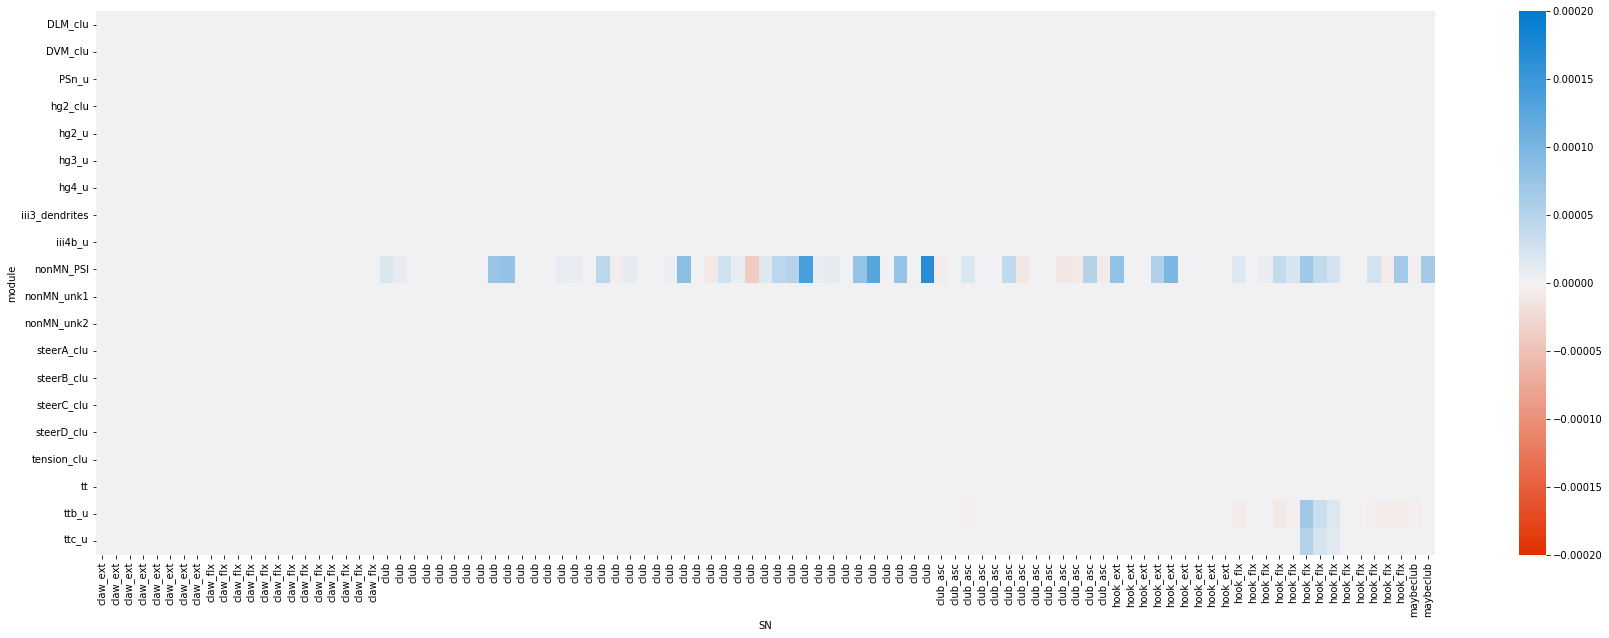

In [22]:
#plot heat map for summed excitatory and inhibitory information
summed_cmap = sns.diverging_palette(15, 250, l=50, s=100, as_cmap=True, sep=1)#sns.color_palette("icefire_r", as_cmap=True)
figure_size = [30,10]


fig = plt.figure(1, figsize = figure_size)
thisdata = w_impact_df.pivot(index = 'module', columns = 'SN', values = 'signed_impact').fillna(0)

FeCO_dict = dict(sorted(FeCO_dict.items(), key=lambda item: item[1])) #sorting this dictionary to get columns into a general order
thisdata = thisdata[list(FeCO_dict.keys())]
thisdata = thisdata.rename(columns=FeCO_dict)

ax = sns.heatmap(data = thisdata, cmap=summed_cmap, vmin=-0.0002, vmax=0.0002)#, norm=LogNorm())